<a href="https://colab.research.google.com/github/cdario79/FiltroFakeNews/blob/main/Filtro_per_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## IMPORTAZIONE LIBRERIE UTILIZZATE

In [1]:
# Text Processing Libraries
import re  # For regular expression operations
import os  # For operating system interfaces
import requests  # For making HTTP requests
from dateutil import parser  # For parsing dates

# Data Manipulation and Analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Data Visualization
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns

# Machine Learning
import pickle  # For saving and loading the trained model
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text to vectors
from sklearn.svm import SVC  # For Support Vector Classification
from sklearn.metrics import classification_report  # For generating classification reports

# Natural Language Processing
import nltk  # For Natural Language Processing
from nltk.tokenize import word_tokenize  # For tokenization
from nltk.tag import pos_tag  # For part-of-speech tagging
from nltk.chunk import ne_chunk  # For named entity recognition
from collections import Counter  # For counting occurrences
from nltk.corpus import stopwords  # For stop words

# Download NLTK data required for tokenization, part-of-speech tagging,
# named entity recognition, and named entities
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

# Advanced Language Processing
import spacy  # For advanced language processing
from spacy.lang.en.stop_words import STOP_WORDS as english_stopwords  # For English stopwords from Spacy

# Load the Spacy model
nlp = spacy.load("en_core_web_sm")  # Load the Spacy model for English

# Gensim for Topic Modeling
import gensim
from gensim import corpora  # For handling corpora of text documents
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint  # For pretty-printing

# Word Cloud
from wordcloud import WordCloud  # For generating word clouds

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## FUNZIONI UTILIZZATE

In [2]:
def download_csv_from_google_drive(file_id):
    """
    Downloads a CSV file from Google Drive given the file_id.

    Args:
        file_id (str): The unique identifier for the Google Drive file.

    Returns:
        str: The absolute path to the downloaded file.
    """

    def get_confirm_token(response):
        """
        Retrieves the confirmation token from the response cookies if present.

        Args:
            response (requests.Response): The response object from the initial request.

        Returns:
            str: The confirmation token if found, otherwise None.
        """
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        """
        Saves the content of the response to a file in chunks.

        Args:
            response (requests.Response): The response object containing the file data.
            destination (str): The destination path where the file will be saved.
        """
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # Filter out keep-alive new chunks
                    f.write(chunk)

    def download_file_from_google_drive(file_id, destination):
        """
        Handles the download process from Google Drive, managing potential confirmation tokens.

        Args:
            file_id (str): The unique identifier for the Google Drive file.
            destination (str): The destination path where the file will be saved.
        """
        URL = "https://drive.google.com/uc?export=download"
        session = requests.Session()

        response = session.get(URL, params={'id': file_id}, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'id': file_id, 'confirm': token}
            response = session.get(URL, params=params, stream=True)

        save_response_content(response, destination)

    file_name = f"{file_id}.csv"

    if not os.path.exists(file_name):
        print(f"File {file_name} non trovato. Scaricamento in corso ...")
        download_file_from_google_drive(file_id, file_name)
        print(f"File {file_name} scaricato correttamente.")
    else:
        print(f"File {file_name} già presente.")

    return os.path.abspath(file_name)

## CARICO E ANALIZZO LE NOTIZIE VERE

In [3]:
ORIGINAL_TRUE_NEWS_DATA_FILE_GDRIVE_ID = '1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f'
original_true_news_csv_path = download_csv_from_google_drive(ORIGINAL_TRUE_NEWS_DATA_FILE_GDRIVE_ID)

File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv non trovato. Scaricamento in corso ...
File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv scaricato correttamente.


In [4]:
df_true = pd.read_csv(original_true_news_csv_path)
df_true.sample(10)

,title,text,subject,date
13739,Pentagon says reviewing 'adjustments' to arms ...,WASHINGTON (Reuters) - The Pentagon said on Mo...,worldnews,"November 27, 2017"
17490,Cyprus president to seek second five-year term...,NICOSIA (Reuters) - Cypriot President Nicos An...,worldnews,"October 14, 2017"
10417,Cleveland newspaper endorses Republican Kasich...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"March 10, 2016"
6291,Trump pick for NSC post Crowley to step down: ...,"WASHINGTON (Reuters) - Monica Crowley, the for...",politicsNews,"January 16, 2017"
19102,"Brooking no dissent, Marine Le Pen takes grip ...",PARIS (Reuters) - Marine Le Pen has acted to r...,worldnews,"September 25, 2017"
6789,US Senate passes bill to fund government throu...,WASHINGTON (Reuters) - The U.S. Senate passed ...,politicsNews,"December 10, 2016"
18606,Spain reluctantly forced to act in Catalan vot...,BARCELONA (Reuters) - The Spanish government w...,worldnews,"October 1, 2017"
19193,"Car bomber hits NATO convoy in Afghanistan, ci...",KABUL (Reuters) - A car bomber attacked a Dani...,worldnews,"September 24, 2017"
2659,China says 'significant progress' was made on ...,BEIJING (Reuters) - China said on Thursday tha...,politicsNews,"July 20, 2017"
1795,Supreme Court justice temporarily preserves Tr...,WASHINGTON (Reuters) - U.S. Supreme Court Just...,politicsNews,"September 11, 2017"


In [5]:
df_true.shape

(21417, 4)

In [6]:
# check null value
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [7]:
df_true.title[df_true.title.str.strip()==''].count()

0

In [8]:
# empty news
df_true.text[df_true.text.str.strip()==''].count()

1

In [9]:
# Trova le righe vuote nel DataFrame
true_text_empty_row = df_true[df_true['text'].str.strip() == '']

true_text_empty_row

,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [10]:
df_true.duplicated().sum()

206

In [11]:
true_duplicated_rows = df_true[df_true.duplicated(keep=False)]
true_duplicated_rows

,title,text,subject,date
416,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
762,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
850,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017"
...,...,...,...,...
21290,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017"
21345,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017"
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017"
21406,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017"


## CARICO E ANALIZZO LE NOTIZIE FALSE

In [12]:
ORIGINAL_FAKE_NEWS_DATA_FILE_GDRIVE_ID = '1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m'
original_fake_news_csv_path = download_csv_from_google_drive(ORIGINAL_FAKE_NEWS_DATA_FILE_GDRIVE_ID)

File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv non trovato. Scaricamento in corso ...
File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv scaricato correttamente.


In [13]:
df_fake = pd.read_csv(original_fake_news_csv_path)
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [14]:
df_fake.shape

(23481, 4)

In [15]:
# check null value
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [16]:
df_fake.title[df_fake.title.str.strip()==''].count()

0

In [17]:
df_fake.text[df_fake.text.str.strip()==''].count()

630

In [18]:
# Trova le righe vuote nel DataFrame
fake_text_empty_row = df_fake[df_fake['text'].str.strip() == '']

fake_text_empty_row

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [19]:
df_fake.duplicated().sum()

3

In [20]:
fake_duplicated_rows = df_fake[df_fake.duplicated(keep=False)]
fake_duplicated_rows

,title,text,subject,date
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"


## Le fake news sono più frequenti in una determinata categoria?

In [21]:
df_fake_cat = df_fake.drop_duplicates()
df_fake_cat['document'] = df_fake_cat['title'] + " " + df_fake_cat['text']
df_fake_cat = df_fake_cat[['subject', 'document']]
df_fake_cat.sample(10)

,subject,document
19257,left-news,3 “MIDDLE EASTERN” Men Arrested For GANG RAPE ...
15707,politics,[Video] US VETERAN FINDS FLAG HE CARRIRED ON T...
9100,politics,MSNBC: “The Trump ‘Resistance’ has to become a...
11657,politics,JAPANESE SCHOOLS DON’T EMPLOY JANITORS…Why Ame...
9977,politics,LOL! Watch Donald Trump’s Greatest Golf Shot [...
31,News,Watch: Is This Proof Trump Is Unfit for Servi...
19060,left-news,"HILLARY VOLUNTEER, Obama Supporter Mocks Ryan ..."
10364,politics,"WOMAN HOSPITALIZED, UNABLE TO FEEL HER LEGS Af..."
22601,US_News,REVEALED: The CIA Ran LSD Sex Houses in San Fr...
19927,left-news,BUSTED! LIBERAL BRAINIACS Steal Trump Sign…In ...


In [22]:
df_fake_cat.shape

(23478, 2)

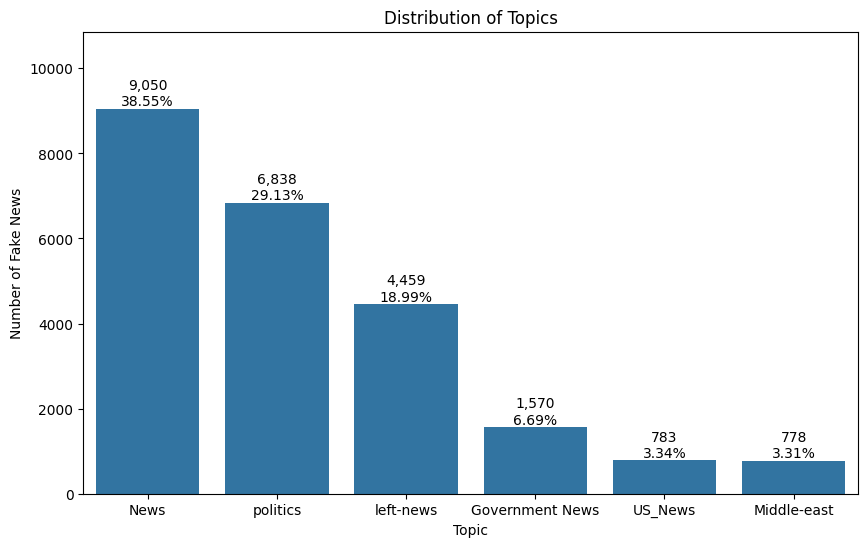

In [23]:
# Calcola il conteggio dei valori nel DataFrame
counts = df_fake_cat['subject'].value_counts()

# Calcola la percentuale rispetto al totale
percentages = counts / counts.sum() * 100

# Ordina il conteggio dal più alto al più basso
counts_sorted = counts.sort_values(ascending=False)

# Crea il countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df_fake['subject'], order=counts_sorted.index)
#ax.bar_label(ax.containers[0])
for i, (index, count) in enumerate(counts_sorted.items()):
    plt.text(i, count + 70, f'{count}\n{percentages[index]:,.2f}%', ha='center', color='black')


# Imposta il range dell'asse y
plt.ylim(0, counts.max() * 1.2)

plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Fake News')
plt.show()

## Per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?

In [73]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import random
from gensim.models import CoherenceModel
from IPython.display import HTML, display

def create_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def preprocess_text(text):
    # Tokenizzazione
    tokens = word_tokenize(text.lower())
    # Rimuovi le stop words e la punteggiatura
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

def get_most_relevant_topic(lda_result):
    if lda_result:
        return max(lda_result, key=lambda x: x[1])[0]
    else:
        return None

def lda_and_wordcloud(category_df, category_name):

    category_documents = category_df['document'].tolist()

    # Prepara il testo per LDA
    texts = [preprocess_text(doc) for doc in category_documents]

    # Creazione del dizionario
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Addestramento del modello LDA
    lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # Calcolo della perplexity
    perplexity = lda_model.log_perplexity(corpus)

    # Calcolo della coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    formatted_text = "<h2>Indici LDA per categoria \"" + category_name + "\"</h2>"
    formatted_text += "<p>Perplexity:" + str(perplexity) + "</p>"
    formatted_text += "<p>Coherence Score:" + str(coherence_lda) + "</p>"
    formatted_text += "<p>&nbsp;</p>"

    # Estrazione degli argomenti
    topics = lda_model.print_topics(num_words=5)

    # Ordiniamo le parole chiave all'interno di ciascun topic per importanza
    sorted_topics = [(topic_num, sorted(topic_str.split(" + "), key=lambda x: float(x.split("*")[0]), reverse=True)) for topic_num, topic_str in topics]

    # Testo formattato in HTML
    formatted_text += "<h2>Topics for " + category_name + " category:</h2>"
    formatted_text += "<ul>"
    for topic_num, topic_words in sorted_topics:
        # Estraiamo solo le parole e i loro pesi
        words_with_weights = [word_weight.split("*") for word_weight in topic_words]

        # Creiamo il formato HTML per ogni topic
        topic_html = "<li><strong>Topic {}:</strong><ul>".format(topic_num)
        for word, weight in words_with_weights:
            # Aggiungiamo il valore di importanza accanto a ciascuna parola
            topic_html += "<li>{}: {}</li>".format(word.strip('\"'), weight)
        topic_html += "</ul></li>"

        formatted_text += topic_html

    formatted_text += "</ul>"

    # Visualizziamo il testo formattato
    display(HTML(formatted_text))

    # Aggiunta del risultato di LDA al DataFrame
    lda_results = [lda_model[dictionary.doc2bow(text)] for text in texts]

    # Aggiunta del risultato di LDA al DataFrame
    lda_results = [lda_model[dictionary.doc2bow(text)] for text in texts]

    # Ordina lda_results dal più importante al meno importante
    lda_results_sorted = [sorted(result, key=lambda x: x[1], reverse=True) for result in lda_results]

    most_relevant_topics = [get_most_relevant_topic(result) for result in lda_results_sorted]

    # Aggiungi la colonna con il numero del topic più rilevante
    category_df['lda_topic'] = lda_results_sorted
    category_df['most_relevant_topic'] = most_relevant_topics

    # Visualizza il DataFrame
    #display(category_df)
    print()

    # Contare la frequenza di ciascun topic
    topic_counts = category_df['most_relevant_topic'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))

    bars = topic_counts.sort_values(ascending=False).plot(kind='bar')

    # Aggiungere le annotazioni alle barre
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), '.0f'),
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                      ha='center', va='center',
                      size=12, xytext=(0, 8),
                      textcoords='offset points')

    plt.title('Frequenza dei Topic Rilevanti')
    plt.xlabel('Topic')
    plt.ylabel('Frequenza')
    plt.xticks(rotation=0)
    plt.show()

    # Creazione di una nuvola di parole
    all_words = [word for doc in category_documents for word in preprocess_text(doc)]
    create_wordcloud(all_words)

In [ ]:
df_fake_cat_topic = df_fake.drop_duplicates()
df_fake_cat_topic['document'] = df_fake_cat_topic['title'] + " " + df_fake_cat_topic['text']
df_fake_cat_topic = df_fake_cat_topic[['subject', 'document']]
df_fake_cat_topic.sample(10)

In [56]:
categories_fake = list(df_fake_cat_topic['subject'].unique())

categories_fake

['News', 'politics', 'Government News', 'left-news', 'US_News', 'Middle-east']

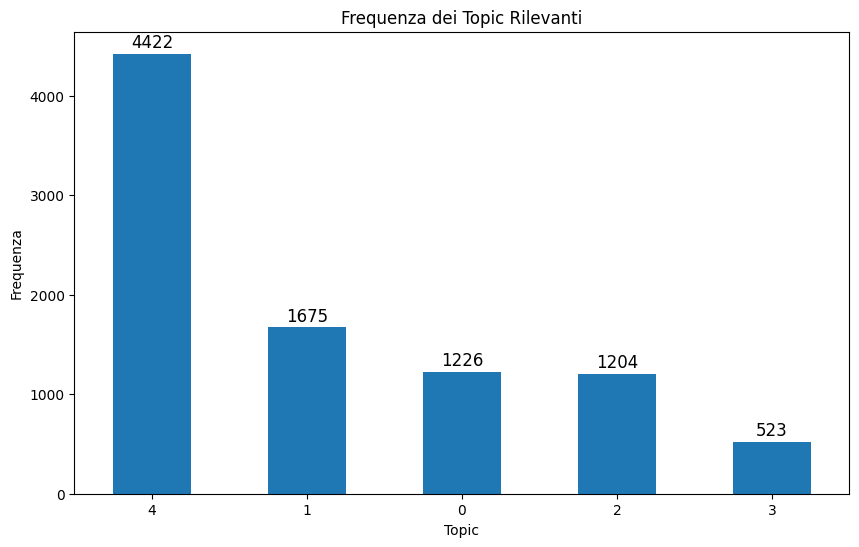

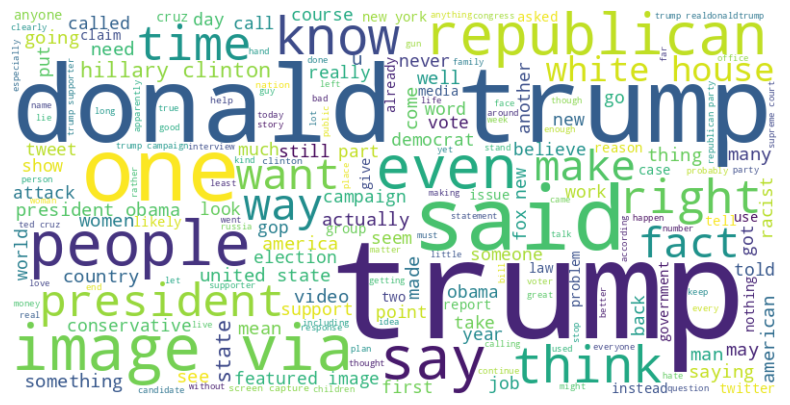

In [72]:
current_category_name = 'News'
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]
lda_and_wordcloud(current_category_df,current_category_name)

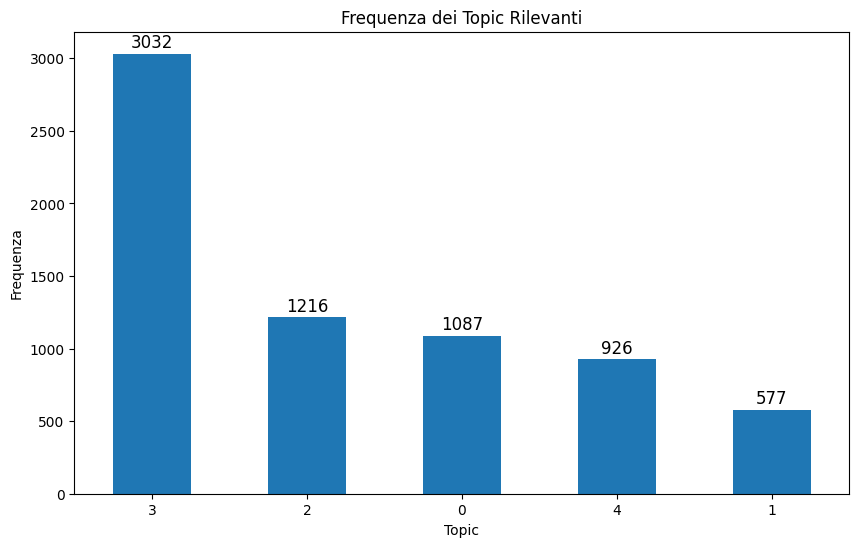

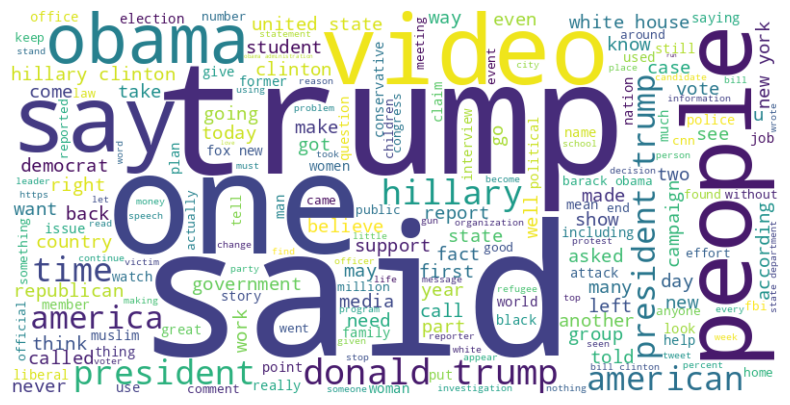

In [71]:
current_category_name = 'politics'
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]
lda_and_wordcloud(current_category_df,current_category_name)

Perplexity: -8.631950234500556
Coherence Score: 0.36118634586721365



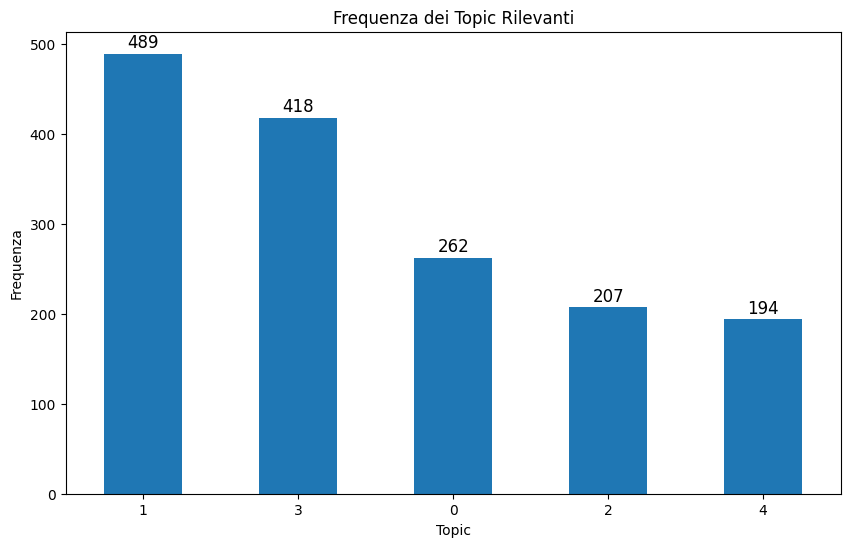

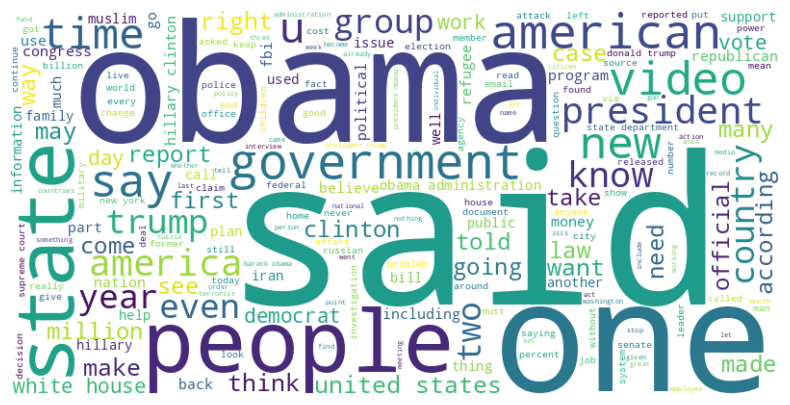

In [67]:
current_category_name = 'Government News'
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]
lda_and_wordcloud(current_category_df,current_category_name)

Perplexity: -8.684788033657698
Coherence Score: 0.38067416480850336

Top 5 topics for left-news category:
(0, '0.015*"police" + 0.013*"said" + 0.005*"officers" + 0.004*"school" + 0.004*"law"')
(1, '0.008*"black" + 0.007*"people" + 0.005*"white" + 0.005*"said" + 0.004*"one"')
(2, '0.006*"illegal" + 0.006*"would" + 0.005*"obama" + 0.005*"state" + 0.005*"states"')
(3, '0.015*"clinton" + 0.014*"hillary" + 0.009*"president" + 0.009*"obama" + 0.007*"said"')
(4, '0.024*"trump" + 0.009*"video" + 0.006*"said" + 0.006*"president" + 0.005*"people"')



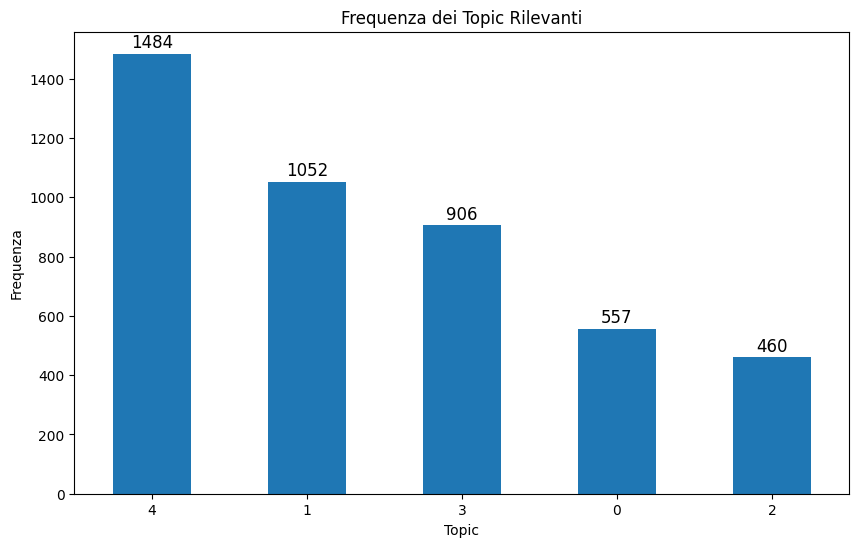

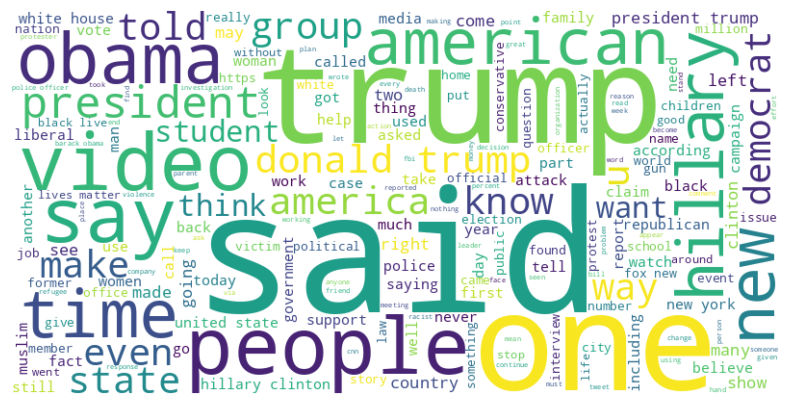

In [59]:
current_category_name = 'left-news'
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]
lda_and_wordcloud(current_category_df,current_category_name)

Perplexity: -8.623620607608851
Coherence Score: 0.4001262949935775

Top 5 topics for US_News category:
(0, '0.005*"state" + 0.004*"trump" + 0.004*"us" + 0.004*"political" + 0.003*"order"')
(1, '0.011*"boiler" + 0.010*"room" + 0.008*"trump" + 0.008*"acr" + 0.006*"pm"')
(2, '0.010*"clinton" + 0.006*"shooting" + 0.004*"cia" + 0.004*"hillary" + 0.004*"fbi"')
(3, '0.010*"us" + 0.007*"syria" + 0.006*"media" + 0.004*"war" + 0.004*"news"')
(4, '0.015*"trump" + 0.007*"us" + 0.006*"news" + 0.006*"wire" + 0.005*"media"')



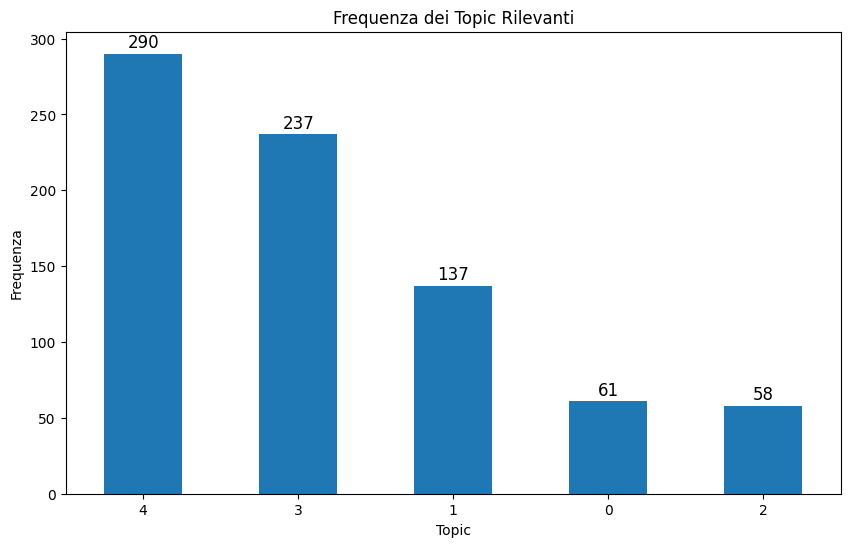

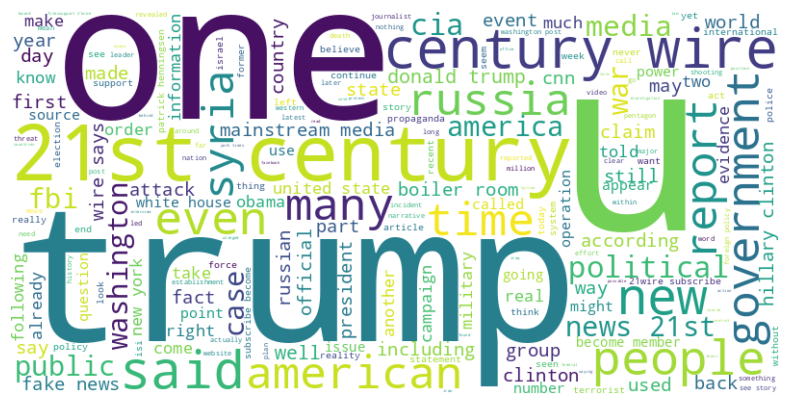

In [58]:
current_category_name = 'US_News'
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]
lda_and_wordcloud(current_category_df,current_category_name)

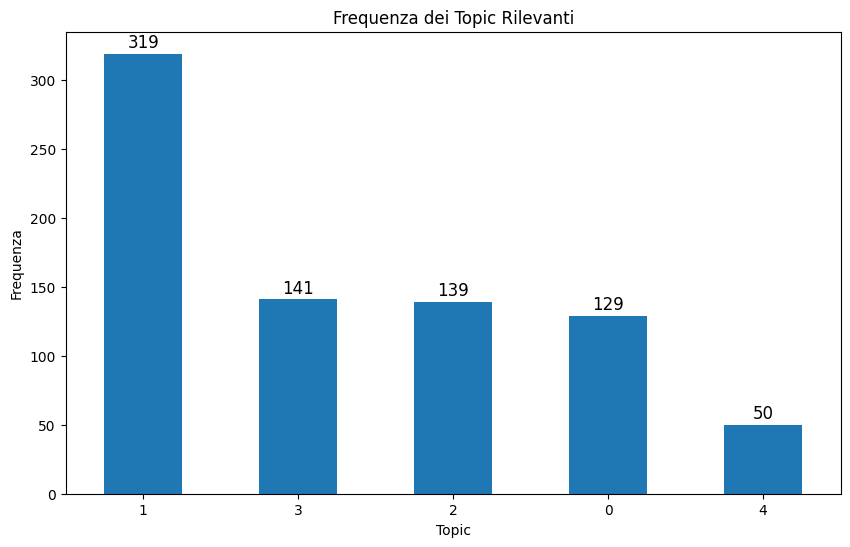

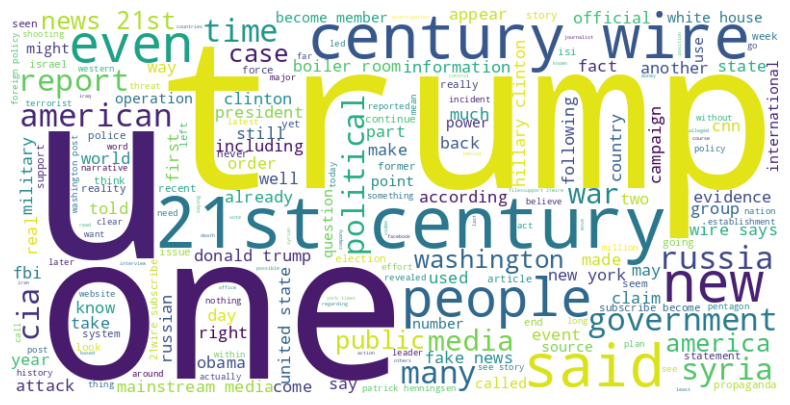

In [74]:
current_category_name = 'Middle-east'
current_category_df = df_fake_cat_topic[df_fake_cat_topic['subject'] == current_category_name]
lda_and_wordcloud(current_category_df,current_category_name)

## I titoli delle fake news presentano dei pattern?

Per determinare se i titoli delle fake news presentano dei pattern, possiamo utilizzare diverse tecniche, tra cui l'analisi delle parti del discorso (POS) e il riconoscimento delle entità nominate (NER), insieme ad altri metodi di analisi del testo.

Ecco come possiamo procedere utilizzando POS e NER:

Analisi delle parti del discorso (POS): Con POS, possiamo identificare i ruoli grammaticali di ciascuna parola nei titoli delle fake news. Ad esempio, possiamo vedere se ci sono schemi comuni nell'uso di determinate categorie di parole (come nomi, verbi, aggettivi) nei titoli delle fake news.

Riconoscimento delle entità nominate (NER): Con NER, possiamo identificare e classificare le entità nominate nei titoli delle fake news, come persone, luoghi, organizzazioni, ecc. Questo ci aiuta a capire se ci sono determinati soggetti o argomenti ricorrenti nelle fake news.

Analisi delle parole chiave e delle frasi: Possiamo esaminare le parole chiave e le frasi più frequenti nei titoli delle fake news per identificare pattern o temi ricorrenti.

Visualizzazione dei risultati: Utilizziamo grafici, nuvole di parole o altri strumenti di visualizzazione per rappresentare i pattern identificati nei titoli delle fake news in modo chiaro e comprensibile.


In [76]:
df_fake_title = df_fake.drop_duplicates()
df_fake_title = df_fake_title[['title']]
print(df_fake_title.shape)
df_fake_title.sample(10)

                                                   title
0       Donald Trump Sends Out Embarrassing New Year’...
1       Drunk Bragging Trump Staffer Started Russian ...
2       Sheriff David Clarke Becomes An Internet Joke...
3       Trump Is So Obsessed He Even Has Obama’s Name...
4       Pope Francis Just Called Out Donald Trump Dur...
...                                                  ...
23476  McPain: John McCain Furious That Iran Treated ...
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
23479  How to Blow $700 Million: Al Jazeera America F...
23480  10 U.S. Navy Sailors Held by Iranian Military ...

[23478 rows x 1 columns]


,title
1905,Dem. Senator Promises To Filibuster Gorsuch B...
15984,FACTORY WORKER RIPS INTO Speaker Paul Ryan on ...
4864,WATCH: Scottie Nell Hughes Calls Clinton A Bi...
19525,BREAKING: CONDI RICE Meets With Mike Pence In ...
15278,SAY WHAT? #BlackLivesMatter TEXTBOOKS TO BE US...
21246,U.S. Air Force Runs Out Of Bombs To Drop On IS...
4761,Obama Shows Why Trump Is Too Much Of A Hothea...
4411,WATCH: Bill Maher Hilariously TORCHES Whiny T...
1808,Trump Campaign Manager Registering As Foreign...
9031,"Jeb! Makes Awkward ‘Hurricane Katrina’ Joke, ..."


In [77]:
#  titoli delle fake news
fake_titles = df_fake_title['title']

# Tokenizzazione e POS tagging
pos_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    pos_tags.extend(pos_tag(words))

# Conteggio delle parti del discorso più comuni
pos_counts = Counter(tag for word, tag in pos_tags)

# Riconoscimento delle entità nominate (NER)
ner_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    ner_tags.extend(ne_chunk(pos_tag(words)))

# Estrazione delle entità nominate
named_entities = [chunk for chunk in ner_tags if hasattr(chunk, 'label')]

# Visualizzazione dei risultati
print("Parti del discorso più comuni:")
print(pos_counts)
print("\nEntità nominate:")
print(named_entities[:10])

Parti del discorso più comuni:
Counter({'NNP': 254649, 'IN': 29430, 'NN': 19159, 'JJ': 10547, 'DT': 9381, 'TO': 8774, ':': 8671, 'VBD': 7375, 'VBZ': 6703, 'PRP': 6626, 'VB': 6483, '.': 5930, 'NNS': 5071, 'VBG': 4521, ',': 4490, '(': 4131, ')': 4131, 'VBP': 3859, 'RB': 3795, 'CD': 3654, 'CC': 3637, 'NNPS': 2720, 'PRP$': 2655, 'VBN': 1565, 'WRB': 1524, 'WP': 943, 'MD': 923, '#': 804, 'RP': 736, '$': 517, 'JJR': 343, 'WDT': 265, 'JJS': 187, 'EX': 170, 'POS': 127, 'UH': 97, 'PDT': 97, 'RBR': 93, 'FW': 71, 'RBS': 57, "''": 27})

Entità nominate:
[Tree('PERSON', [('Donald', 'NNP')]), Tree('PERSON', [('Trump', 'NNP')]), Tree('GPE', [('New', 'NNP')]), Tree('PERSON', [('Eve', 'NNP'), ('Message', 'NNP')]), Tree('PERSON', [('Drunk', 'NNP')]), Tree('ORGANIZATION', [('Bragging', 'NNP'), ('Trump', 'NNP'), ('Staffer', 'NNP')]), Tree('GPE', [('Russian', 'NNP')]), Tree('PERSON', [('Sheriff', 'NN')]), Tree('PERSON', [('David', 'NNP'), ('Clarke', 'NNP'), ('Becomes', 'NNP'), ('An', 'DT'), ('Internet', 'NN

Sì, i titoli delle fake news spesso presentano alcuni pattern ricorrenti nelle parti del discorso. Tuttavia, i modelli esatti possono variare a seconda del contesto e delle tendenze specifiche delle fake news in un dato momento. Alcuni pattern comuni potrebbero includere un'elevata frequenza di nomi propri (NNP) per attirare l'attenzione sugli argomenti o sulle persone coinvolte, un alto numero di aggettivi (JJ) per enfatizzare certi aspetti dell'articolo, e una frequenza significativa di verbi (VB) per creare un senso di azione o dramma nel titolo.

Alcuni esempi di pattern potrebbero essere:

L'uso di nomi propri seguiti da verbi o aggettivi forti per creare impatto emotivo.
Una frequenza elevata di verbi al passato (VBD) per dare un senso di autorità o veridicità.
La presenza di pronomi personali (PRP) o pronomi possessivi (PRP$) per rendere il titolo più coinvolgente.
L'uso di avverbi (RB) per aumentare l'intensità del messaggio.
Tuttavia, è importante notare che queste sono solo possibili tendenze e che i titoli delle fake news possono variare ampiamente nel loro stile e nella loro struttura.

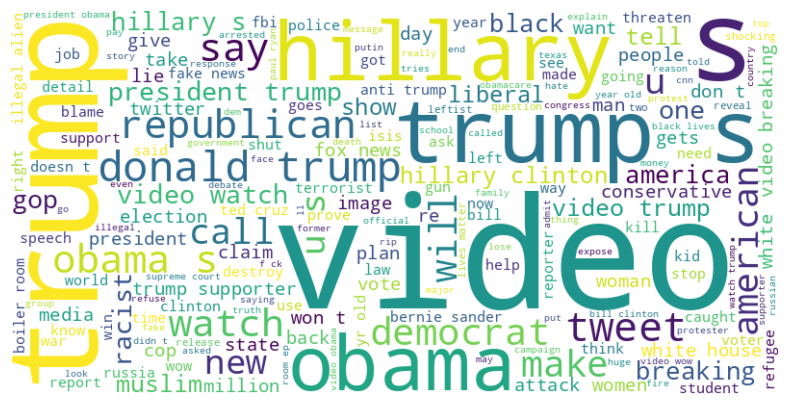

In [78]:
# Estrazione delle parole dai titoli delle fake news
words_fake = [word.lower() for title in fake_titles for word in word_tokenize(title)]

# Creazione della nuvola di parole
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words_fake))

# Visualizzazione della nuvola di parole
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Creazione modello per identificare fake news

In [84]:
df_true_cleaned = df_true.drop_duplicates()
df_true_cleaned['document'] = df_true_cleaned['title'] + " " + df_true_cleaned['text']
df_true_cleaned = df_true_cleaned[['document']]
df_true_cleaned["label"] = 0
df_true_cleaned

,document,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,0
21413,LexisNexis withdrew two products from Chinese ...,0
21414,Minsk cultural hub becomes haven from authorit...,0
21415,Vatican upbeat on possibility of Pope Francis ...,0


In [82]:
df_fake_cleaned = df_fake.drop_duplicates()
df_fake_cleaned['document'] = df_fake_cleaned['title'] + " " + df_fake_cleaned['text']
df_fake_cleaned = df_fake_cleaned[['document']]
df_fake_cleaned["label"] = 1
df_fake_cleaned

,document,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,1
23479,How to Blow $700 Million: Al Jazeera America F...,1


In [85]:
# Aggiungi una colonna "label" per distinguere tra notizie vere (1) e false (0)
df_true_label = df_true_cleaned.copy()
df_true_label['label'] = 1
df_fake_label = df_fake_cleaned.copy()
df_fake_label['label'] = 0

# Unisci i dataset
df_full = pd.concat([df_true_label, df_fake_label])
df_full.sample(15)

,document,label
15056,BREAKING: [Video] Obama’s State Dept Miraculou...,0
19557,Police deploy in Iraqi oil city as tensions ri...,1
15723,"Promote peace, China's Xi tells soldiers at fi...",1
10813,Republicans gear up for Supreme Court battle a...,1
9618,Commentary: Party leaders often disliked their...,1
9659,HANNITY TEARS IT UP IN HIS BEST EVER RANT: ‘Hi...,0
22262,Trump Swings Back at Author of Fake Dossier: ‘...,0
17831,"BYE-BYE HARVEY! WEINSTEIN’S WIFE, Mother of Hi...",0
12928,FOOTBALL LEGEND MIKE DITKA Weighs In On Nation...,0
8233,Ted Nugent Attacks Jews Who Support Gun Contr...,0


In [86]:
# Preprocessing dei dati
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df_full['document'])
y = df_full['label']

# Dividi i dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addestramento del modello SVM
svm_model = SVC(kernel='linear', C=1.0)  # Utilizziamo un kernel lineare
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

## VALUTAZIONE DEL MODELLO

In [87]:
# Valutazione del modello
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4648
           1       1.00      0.99      0.99      4290

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



## Esportazione del Modello

Una volta soddisfatto delle prestazioni del modello, esportalo utilizzando la libreria pickle in Python.
Assicurati di includere le istruzioni necessarie per caricare e utilizzare il modello.

In [88]:
import pickle
# Salva il modello utilizzando pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

## ISTRUZIONI USO MODELLO SALVATO

Per caricare e utilizzare un modello SVM salvato con il formato pickle in Python, puoi seguire questi passaggi:

Importa le librerie necessarie:
python
Copia codice
import pickle
from sklearn import svm
Carica il modello SVM dal file pickle:
python
Copia codice
with open('nome_file_modello.pkl', 'rb') as f:
    modello_svm = pickle.load(f)
Assicurati di sostituire 'nome_file_modello.pkl' con il percorso e il nome del file in cui hai salvato il modello SVM.

Utilizza il modello per fare previsioni:
python
Copia codice
# Esempio di dati di input per la previsione
dato_di_input = [[valore_feature1, valore_feature2, ...]]

# Fai previsioni utilizzando il modello
previsione = modello_svm.predict(dato_di_input)
Con questi passaggi, hai caricato il modello SVM precedentemente salvato con pickle e hai fatto previsioni utilizzandolo con nuovi dati di input.

Ricorda di sostituire 'valore_feature1', 'valore_feature2', ... con i valori effettivi delle tue feature quando fai previsioni.